In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import umap
from scipy import stats
pd.set_option('display.max_rows', 50)
np.set_printoptions(threshold=50)
import joblib
from scipy.stats import fisher_exact
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from matplotlib import cm
import statsmodels.api as sm
from sklearn.cluster import AgglomerativeClustering
from joblib import load
import pickle
from joblib import dump
from sklearn.metrics import silhouette_score

# Load analysis datasets

In [2]:
alldiag_pivot = pd.read_parquet('pivot_table_final1.parquet')

# Dimentional Reduction

## (If necessary) Sampling from the dataset

In [3]:
alldiag_pivot_sp = alldiag_pivot

In [4]:
y = alldiag_pivot_sp["isAD"].replace({1:"Alzheimer", 0:"Control"})

In [5]:
demographic_cols = ['Age', 'Sex', 'Race', 'Death_Status','#diagnosis']

In [6]:
z = alldiag_pivot_sp[demographic_cols]
X = alldiag_pivot_sp.drop('isAD', axis=1).drop(demographic_cols, axis=1).astype('int32')

In [7]:
X

,"""walking corpse"" syndrome",'light-for-dates' infant with signs of fetal malnutrition,(HFpEF) heart failure with preserved ejection fraction (HCC),(Idiopathic) normal pressure hydrocephalus (HCC),*Unknown,1st MTP arthritis,1st degree AV block,"2-part displaced fracture of surgical neck of right humerus, initial encounter for closed fracture","2-part displaced fracture of surgical neck of right humerus, subsequent encounter for fracture with routine healing","2-part nondisplaced fracture of surgical neck of left humerus, initial encounter for closed fracture",...,Zenker diverticula,Zenker's hypopharyngeal diverticulum,Zonular dehiscence,Zoster iridocyclitis,Zoster vaccine,"Zygomatic fracture, left side, initial encounter for closed fracture (HCC)","Zygomatic fracture, unspecified side, initial encounter for open fracture (HCC)","Zygomatic fracture, unspecified side, subsequent encounter for fracture with routine healing",Zygomatic hyperplasia,Zygomycosis (phycomycosis or mucormycosis) (HCC)
PatientID,,,,,,,,,,,,,,,,,,,,,
D0003B2687D8F9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D000D5B83D9620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D000D6884BD199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D0016F824B7B74,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D00195531E21B1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DFFE8107CDA348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DFFF1B8ED4683F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DFFF226D09433C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## PCA(n=1750)

In [8]:
pca = joblib.load('pca1750_model.joblib')
data_pca = np.load('data_pca1750_final1.npy')

## Agglome Clustering

In [9]:
agg2 = AgglomerativeClustering(n_clusters=2) 
agg2.fit(data_pca)
data_pca_agg2 = agg2.fit_predict(data_pca)

In [10]:
agg2_labels = agg2.labels_

## UMAP Visualization by Cluster

In [11]:
with open('umap_results.pkl', 'rb') as file:
    X_embedded = pickle.load(file)

In [12]:
loaded_umap_model = load('umap_model.joblib')

Sat Mar  9 23:43:35 2024 Building and compiling search function


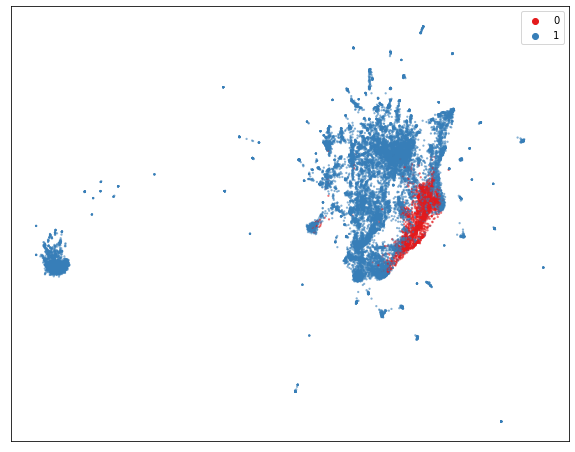

In [13]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = agg2.labels_[reordered_indices], 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')

## UMAP Visualization colored by AD

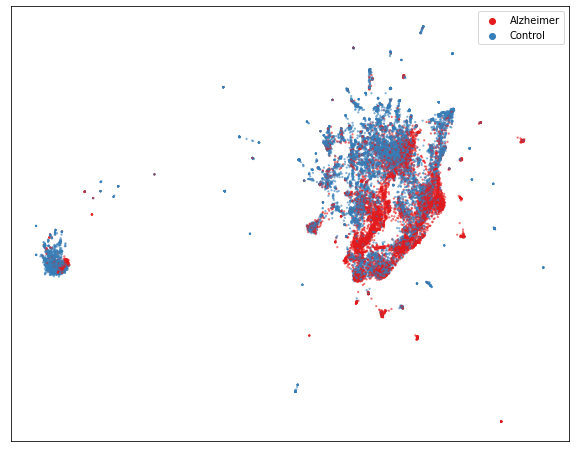

In [14]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    np.random.seed(0)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = y[reordered_indices].values, 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')

## Odds Ratio

In [15]:
# Cross table of cluster and AD
cross_tab = pd.crosstab(agg2_labels, y)

# Calculate Odds ratio
odds_ratio, p_value = fisher_exact(cross_tab)

print("Odds Ratio:", odds_ratio)
print("P-value:", p_value)

Odds Ratio: 2.8540754888508344
P-value: 2.640478752861899e-131


In [16]:
cross_tab

isAD,Alzheimer,Control
row_0,,
0,1618,916
1,7186,11611


In [17]:
X['cluster1'] = agg2_labels

In [18]:
y_float = y.replace({"Alzheimer":1, "Control":0})

# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X['cluster1'] , y_float, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_with_intercept = sm.add_constant(X_train.astype(float))

# Train the logistic model on the train data
log_model1 = sm.Logit(y_train, X_with_intercept)
log_reg1 = log_model1.fit()

print(log_reg1.summary())

Optimization terminated successfully.
         Current function value: 0.663444
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                   isAD   No. Observations:                17064
Model:                          Logit   Df Residuals:                    17062
Method:                           MLE   Df Model:                            1
Date:                Sat, 09 Mar 2024   Pseudo R-squ.:                 0.02115
Time:                        23:43:39   Log-Likelihood:                -11321.
converged:                       True   LL-Null:                       -11566.
Covariance Type:            nonrobust   LLR p-value:                2.142e-108
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5818      0.046     12.556      0.000       0.491       0.673
cluster1      -1.0640      0.

In [19]:
# Calculate the accuracy on the test data
X_test_sm = sm.add_constant(X_test)

y_pred_prob = log_reg1.predict(X_test_sm)

# set the threshold is 0.5
y_pred_class = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

Accuracy: 0.6168268104054371


# Re-Kmeans Clustering after narrow down the data

In [20]:
# Choose a cluster that have the maximum coefficient
selected_cluster = np.argmin(log_reg1.params)
selected_data = data_pca[agg2_labels == selected_cluster]

# Re-Kmeans clustering to the selected cluster
recluster_agg = AgglomerativeClustering(n_clusters=2)
recluster_agg.fit(selected_data)
recluster_labels = recluster_agg.labels_

In [21]:
sub_labels = recluster_labels

In [22]:
final_labels = agg2_labels.copy()
if selected_cluster == 1 :
    final_labels[agg2_labels == selected_cluster] = sub_labels + 1  # New cluster labels are 1 and 2 because cluster 0 alreadt existed.
elif selected_cluster ==0 :
    final_labels[agg2_labels == selected_cluster] = sub_labels + 2  # New cluster labels are 2 and 3 because cluster 1 alreadt existed.

In [23]:
np.unique(final_labels)

array([0, 1, 2])

## UMAP Visualization

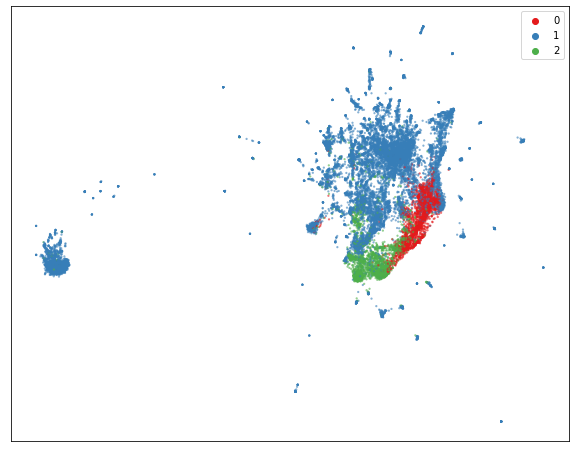

In [24]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = final_labels[reordered_indices], 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')

## Odds Ratio

In [25]:
selected_y = y[agg2_labels == selected_cluster]


In [26]:
# Cross table of cluster and AD
cross_tab = pd.crosstab(recluster_labels, selected_y)

# Calculate Odds ratio
odds_ratio, p_value = fisher_exact(cross_tab)

print("Odds Ratio:", odds_ratio)
print("P-value:", p_value)

Odds Ratio: 0.5477729179362564
P-value: 2.0448536250620085e-49


In [27]:
cross_tab

isAD,Alzheimer,Control
row_0,,
0,5712,10173
1,1474,1438


In [28]:
sub_labels = recluster_labels

In [29]:
sub_label_df = pd.DataFrame(sub_labels, columns = ['cluster2'])

In [30]:
y_float = selected_y.replace({"Alzheimer":1, "Control":0})

# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(sub_label_df , y_float, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_with_intercept = sm.add_constant(X_train.astype(float))

# Train the logistic model on the train data
log_model2 = sm.Logit(y_train, X_with_intercept)
log_reg2 = log_model2.fit()

print(log_reg2.summary())

Optimization terminated successfully.
         Current function value: 0.660582
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                   isAD   No. Observations:                15037
Model:                          Logit   Df Residuals:                    15035
Method:                           MLE   Df Model:                            1
Date:                Sat, 09 Mar 2024   Pseudo R-squ.:                0.008574
Time:                        23:50:26   Log-Likelihood:                -9933.2
converged:                       True   LL-Null:                       -10019.
Covariance Type:            nonrobust   LLR p-value:                 2.981e-39
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5667      0.018    -30.673      0.000      -0.603      -0.530
cluster2       0.5939      0.

In [31]:
# Calculate the accuracy on the test data
X_test_sm = sm.add_constant(X_test)

y_pred_prob = log_reg2.predict(X_test_sm)

# set the threshold is 0.5
y_pred_class = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

Accuracy: 0.6281914893617021


# Re-Kmeans Clustering after narrow down the data

In [32]:
# Choose a cluster that have the maximum coefficient
selected_cluster = np.argmin(log_reg2.params)
selected_data1 = selected_data[sub_labels == selected_cluster]

# Re-Kmeans clustering to the selected cluster
recluster_agg1 = AgglomerativeClustering(n_clusters=2)
recluster_agg1.fit(selected_data1)
recluster_labels1 = recluster_agg1.labels_

In [33]:
final_labels_1 = final_labels.copy()
if selected_cluster == 1 :
    final_labels_1[final_labels == 2] = recluster_labels1 + 2  # New cluster labels are 2 and 3
elif selected_cluster ==0 :
    final_labels_1[final_labels == 1] = recluster_labels1 + 3  # New cluster labels are 3 and 4

In [34]:
np.unique(final_labels_1)

array([0, 2, 3, 4])

## UMAP Visualization

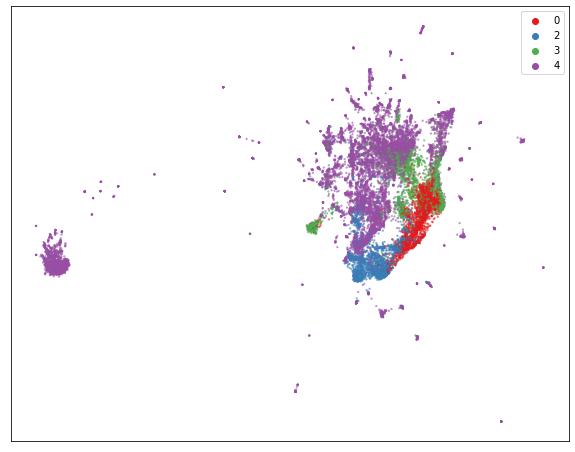

In [35]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = final_labels_1[reordered_indices], 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')

## Odds Ratio

In [36]:
label_df = pd.DataFrame(recluster_labels1, columns=['labels'])

In [37]:
selected_y_1 = selected_y[recluster_labels == selected_cluster]

In [38]:
# Cross table of cluster and AD
cross_tab = pd.crosstab(recluster_labels1, selected_y_1)

# Calculate Odds ratio
odds_ratio, p_value = fisher_exact(cross_tab)

print("Odds Ratio:", odds_ratio)
print("P-value:", p_value)

Odds Ratio: 1.442610727636674
P-value: 4.352579287354873e-17


In [39]:
cross_tab

isAD,Alzheimer,Control
row_0,,
0,1142,1502
1,4570,8671


In [40]:
sub_label_df = pd.DataFrame(recluster_labels1, columns = ['cluster4'])

In [41]:
y_float = selected_y_1.replace({"Alzheimer":1, "Control":0})

# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(sub_label_df , y_float, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_with_intercept = sm.add_constant(X_train.astype(float))

# Train the logistic model on the train data
log_model4 = sm.Logit(y_train, X_with_intercept)
log_reg4 = log_model4.fit()

print(log_reg4.summary())

Optimization terminated successfully.
         Current function value: 0.652853
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                   isAD   No. Observations:                12708
Model:                          Logit   Df Residuals:                    12706
Method:                           MLE   Df Model:                            1
Date:                Sat, 09 Mar 2024   Pseudo R-squ.:                0.002315
Time:                        23:55:16   Log-Likelihood:                -8296.5
converged:                       True   LL-Null:                       -8315.7
Covariance Type:            nonrobust   LLR p-value:                 5.456e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3189      0.044     -7.279      0.000      -0.405      -0.233
cluster4      -0.3016      0.

In [42]:
# Calculate the accuracy on the test data
X_test_sm = sm.add_constant(X_test)

y_pred_prob = log_reg4.predict(X_test_sm)

# set the threshold is 0.5
y_pred_class = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

Accuracy: 0.6487252124645893


## Compare the clusters by Logistic Regression

In [43]:
X['Cluster4'] = final_labels_1

In [44]:
# OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop= "first")

# Encoding the Cluster id
X_encoded = encoder.fit_transform(X[['Cluster4']])

# Data Frame of the encoded clusters
X_encoded_df = pd.DataFrame(X_encoded, columns=[f'Cluster_{i+1}' for i in range(X_encoded.shape[1])])

In [45]:
X_encoded_df

,Cluster_1,Cluster_2,Cluster_3
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,1.0,0.0
...,...,...,...
21326,0.0,1.0,0.0
21327,0.0,0.0,1.0
21328,0.0,0.0,1.0
21329,0.0,0.0,1.0


In [46]:
y_float = y.replace({"Alzheimer":1, "Control":0})

# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X_encoded_df, y_float, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_with_intercept = sm.add_constant(X_train.astype(float))

log_model4_1 = sm.Logit(y_train, X_with_intercept)
log_reg4_1 = log_model4_1.fit()

print(log_reg4_1.summary())

Optimization terminated successfully.
         Current function value: 0.657362
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                   isAD   No. Observations:                17064
Model:                          Logit   Df Residuals:                    17060
Method:                           MLE   Df Model:                            3
Date:                Sat, 09 Mar 2024   Pseudo R-squ.:                 0.03012
Time:                        23:55:26   Log-Likelihood:                -11217.
converged:                       True   LL-Null:                       -11566.
Covariance Type:            nonrobust   LLR p-value:                1.048e-150
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5818      0.046     12.556      0.000       0.491       0.673
Cluster_1     -0.5948      0.

# Re-Kmeans Clustering after narrow down the data

In [47]:
# Choose a cluster that have the maximum coefficient
selected_cluster = np.argmin(log_reg4.params)
selected_data2 = selected_data1[recluster_labels1 == selected_cluster]

# Re-Kmeans clustering to the selected cluster
recluster_agg2 = AgglomerativeClustering(n_clusters=2)
recluster_agg2.fit(selected_data2)
recluster_labels2 = recluster_agg2.labels_

In [48]:
final_labels_2 = final_labels_1.copy()
if selected_cluster == 1 :
    final_labels_2[final_labels_1 == 4] = recluster_labels2 + 4  # New cluster labels are 4 and 5
elif selected_cluster ==0 :
    final_labels_2[final_labels_1 == 3] = recluster_labels2 + 5  # New cluster labels are 5 and 6

In [49]:
np.unique(final_labels_2)

array([0, 2, 4, 5, 6])

## UMAP Visualization

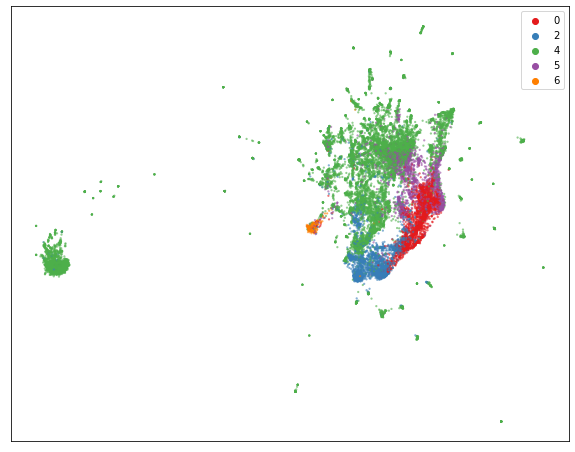

In [50]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = final_labels_2[reordered_indices], 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')

## Odds Ratio

In [51]:
#X_selected = X[X["cluster1"] == selected_cluster]

In [52]:
label_df = pd.DataFrame(recluster_labels2, columns=['labels'])

In [53]:
selected_y_2 = selected_y_1[recluster_labels1 == selected_cluster]

In [54]:
# Cross table of cluster and AD
cross_tab = pd.crosstab(recluster_labels2, selected_y_2)

# Calculate Odds ratio
odds_ratio, p_value = fisher_exact(cross_tab)

print("Odds Ratio:", odds_ratio)
print("P-value:", p_value)

Odds Ratio: 1.5144282151763448
P-value: 0.00010004793448639419


In [55]:
cross_tab

isAD,Alzheimer,Control
row_0,,
0,981,1203
1,161,299


In [56]:
sub_label_df = pd.DataFrame(recluster_labels2, columns = ['cluster6'])

In [57]:
y_float = selected_y_2.replace({"Alzheimer":1, "Control":0})

# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(sub_label_df , y_float, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_with_intercept = sm.add_constant(X_train.astype(float))

# Train the logistic model on the train data
log_model6 = sm.Logit(y_train, X_with_intercept)
log_reg6 = log_model6.fit()

print(log_reg6.summary())

Optimization terminated successfully.
         Current function value: 0.680995
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                   isAD   No. Observations:                 2115
Model:                          Logit   Df Residuals:                     2113
Method:                           MLE   Df Model:                            1
Date:                Sat, 09 Mar 2024   Pseudo R-squ.:                0.004639
Time:                        23:55:36   Log-Likelihood:                -1440.3
converged:                       True   LL-Null:                       -1447.0
Covariance Type:            nonrobust   LLR p-value:                 0.0002484
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1970      0.048     -4.103      0.000      -0.291      -0.103
cluster6      -0.4348      0.

In [58]:
# Calculate the accuracy on the test data
X_test_sm = sm.add_constant(X_test)

y_pred_prob = log_reg6.predict(X_test_sm)

# set the threshold is 0.5
y_pred_class = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

Accuracy: 0.5727788279773157


# Re-Kmeans Clustering after narrow down the data

In [59]:
# Choose a cluster that have the maximum coefficient
selected_cluster = np.argmin(log_reg6.params)
selected_data3 = selected_data2[recluster_labels2 == selected_cluster]

# Re-Kmeans clustering to the selected cluster
recluster_agg3 = AgglomerativeClustering(n_clusters=2)
recluster_agg3.fit(selected_data3)
recluster_labels3 = recluster_agg3.labels_

In [60]:
final_labels_3 = final_labels_2.copy()
if selected_cluster == 1 :
    final_labels_3[final_labels_2 == 6] = recluster_labels3 + 6  # New cluster labels are 5 and 6
elif selected_cluster ==0 :
    final_labels_3[final_labels_2 == 5] = recluster_labels3 + 7  # New cluster labels are 6 and 7

In [61]:
np.unique(final_labels_3)

array([0, 2, 4, 5, 6, 7])

## UMAP Visualization

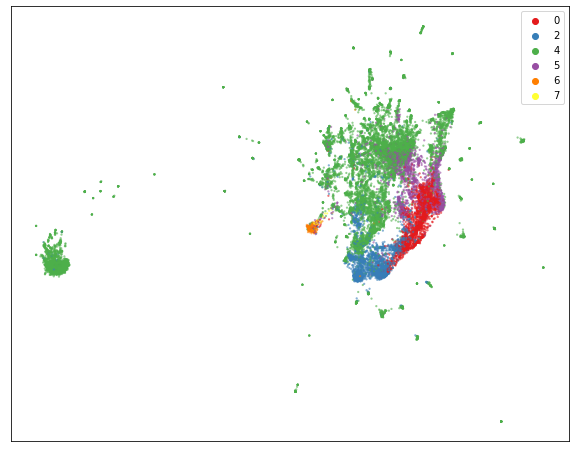

In [62]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = final_labels_3[reordered_indices], 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')

## Elbow Plot

In [63]:
X.columns

Index(['"walking corpse" syndrome',
       ''light-for-dates' infant with signs of fetal malnutrition',
       '(HFpEF) heart failure with preserved ejection fraction (HCC)',
       '(Idiopathic) normal pressure hydrocephalus (HCC)', '*Unknown',
       '1st MTP arthritis', '1st degree AV block',
       '2-part displaced fracture of surgical neck of right humerus, initial encounter for closed fracture',
       '2-part displaced fracture of surgical neck of right humerus, subsequent encounter for fracture with routine healing',
       '2-part nondisplaced fracture of surgical neck of left humerus, initial encounter for closed fracture',
       ...
       'Zonular dehiscence', 'Zoster iridocyclitis', 'Zoster vaccine',
       'Zygomatic fracture, left side, initial encounter for closed fracture (HCC)',
       'Zygomatic fracture, unspecified side, initial encounter for open fracture (HCC)',
       'Zygomatic fracture, unspecified side, subsequent encounter for fracture with routine healing

In [64]:
X = X.drop(['cluster1', 'Cluster4'], axis=1)

In [65]:
n_clusters2 = len(np.unique(agg2_labels))
n_clusters3 = len(np.unique(final_labels))
n_clusters4 = len(np.unique(final_labels_1))
n_clusters5 = len(np.unique(final_labels_2))
n_clusters6 = len(np.unique(final_labels_3))

cluster_centers2 = []
cluster_centers3 = []
cluster_centers4 = []
cluster_centers5 = []
cluster_centers6 = []


for i in range(n_clusters2):

    cluster_data = data_pca[agg2_labels == i]
    
    cluster_center = np.mean(cluster_data, axis=0)
    cluster_centers2.append(cluster_center)
    
for i in range(n_clusters3):
    cluster_data = data_pca[final_labels == i]
    
    cluster_center = np.mean(cluster_data, axis=0)
    cluster_centers3.append(cluster_center)
    
    
for i in range(n_clusters4):
    cluster_data = data_pca[final_labels_1 == i]
    
    cluster_center = np.mean(cluster_data, axis=0)
    cluster_centers4.append(cluster_center)
    
for i in range(n_clusters5):
    cluster_data = data_pca[final_labels_2 == i]
    
    cluster_center = np.mean(cluster_data, axis=0)
    cluster_centers5.append(cluster_center)
    
for i in range(n_clusters6):
    cluster_data = data_pca[final_labels_3 == i]
    
    cluster_center = np.mean(cluster_data, axis=0)
    cluster_centers6.append(cluster_center)

wss2 = 0
wss3 = 0
wss4 = 0
wss5 = 0
wss6 = 0

for i in range(n_clusters2):
    cluster_data = data_pca[agg2_labels == i]
    cluster_center = cluster_centers2[i]
    
    wss2 += np.sum((cluster_data - cluster_center) ** 2)

print('WSS:', wss2)

for i in range(n_clusters3):
    cluster_data = data_pca[final_labels == i]
    cluster_center = cluster_centers3[i]
    
    wss3 += np.sum((cluster_data - cluster_center) ** 2)

print('WSS:', wss3)

for i in range(n_clusters4):
    cluster_data = data_pca[final_labels_1 == i]
    cluster_center = cluster_centers4[i]
    
    wss4 += np.sum((cluster_data - cluster_center) ** 2)

print('WSS:', wss4)

for i in range(n_clusters5):
    cluster_data = data_pca[final_labels_2 == i]
    cluster_center = cluster_centers5[i]
    
    wss5 += np.sum((cluster_data - cluster_center) ** 2)

print('WSS:', wss5)

for i in range(n_clusters6):
    cluster_data = data_pca[final_labels_3 == i]
    cluster_center = cluster_centers6[i]
    
    wss6 += np.sum((cluster_data - cluster_center) ** 2)

print('WSS:', wss6)


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


WSS: 686606.736263395
WSS: 680650.7017665429
WSS: 565670.2299443687
WSS: 584634.0894104353
WSS: 661290.2769973233


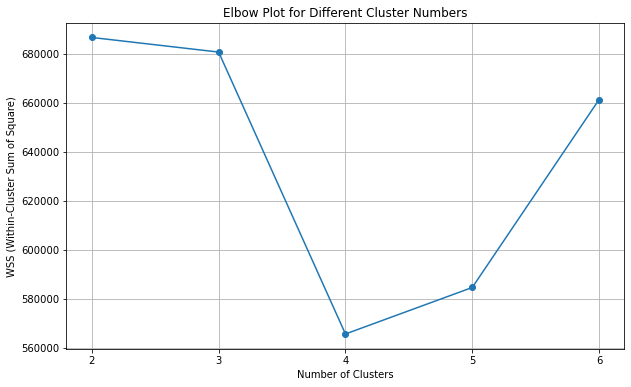

In [66]:
cluster_numbers = [n_clusters2, n_clusters3, n_clusters4, n_clusters5, n_clusters6]
wss_values = [wss2, wss3, wss4, wss5,wss6]

plt.figure(figsize=(10, 6))
plt.plot(cluster_numbers, wss_values, marker='o', linestyle='-')
plt.title('Elbow Plot for Different Cluster Numbers')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS (Within-Cluster Sum of Square)')
plt.xticks(cluster_numbers)
plt.grid(True)
plt.show()


In [67]:
silhouette_avg2 = silhouette_score(data_pca, agg2_labels)
silhouette_avg3 = silhouette_score(data_pca, final_labels)
silhouette_avg4 = silhouette_score(data_pca, final_labels_1)
silhouette_avg5 = silhouette_score(data_pca, final_labels_2)
silhouette_avg6 = silhouette_score(data_pca, final_labels_3)

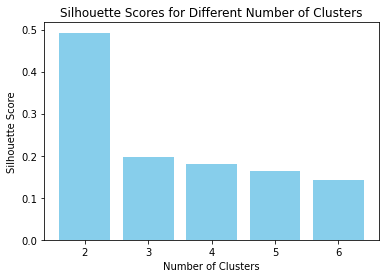

In [68]:
silhouette_avgs = [silhouette_avg2, silhouette_avg3, silhouette_avg4, silhouette_avg5, silhouette_avg6]


n_clusters = [2, 3, 4, 5, 6]

plt.bar(n_clusters, silhouette_avgs, color='skyblue')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Number of Clusters')
plt.xticks(n_clusters)
plt.show()

# The best number of clusters is 4

In [69]:
np.unique(final_labels_1)

array([0, 2, 3, 4])

In [70]:
final_labels_1[final_labels_1 ==0]=1

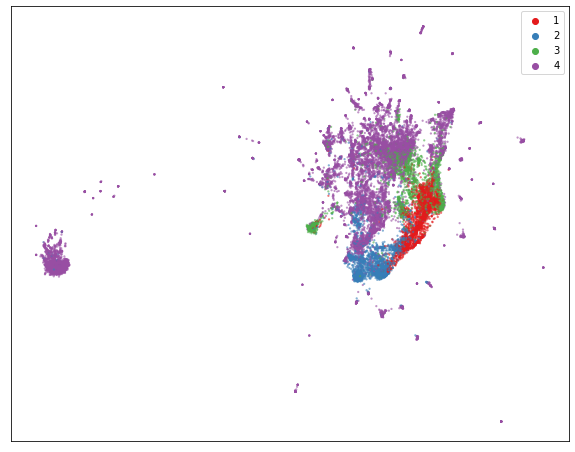

In [71]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = final_labels_1[reordered_indices], 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')

In [72]:
X['Cluster3'] = final_labels_1

In [73]:
# OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop= "first")

# Encoding the Cluster id
X_encoded = encoder.fit_transform(X[['Cluster3']])

# Data Frame of the encoded clusters
X_encoded_df = pd.DataFrame(X_encoded, columns=[f'Cluster_{i+2}' for i in range(X_encoded.shape[1])])

In [74]:
X_encoded_df

,Cluster_2,Cluster_3,Cluster_4
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,1.0,0.0
...,...,...,...
21326,0.0,1.0,0.0
21327,0.0,0.0,1.0
21328,0.0,0.0,1.0
21329,0.0,0.0,1.0


In [75]:
X_encoded_df.index = z.index

In [76]:
df_bg = z.join(X_encoded_df)

In [77]:
labels = pd.DataFrame(final_labels_1, columns=['Cluster'])

In [78]:
labels.index = df_bg.index

In [79]:
df_bg = df_bg.join(labels)

In [80]:
AD = pd.DataFrame(y, columns = ['isAD'])

In [81]:
df_bg = df_bg.join(AD)

In [82]:
df_bg.to_csv('df_agg_cluster4_final1.csv', index=False)

In [83]:
df_bg

,Age,Sex,Race,Death_Status,#diagnosis,Cluster_2,Cluster_3,Cluster_4,Cluster,isAD
PatientID,,,,,,,,,,
D0003B2687D8F9,88,Female,White or Caucasian,Alive,7.0,0.0,0.0,1.0,4,Alzheimer
D000D5B83D9620,91,Female,White or Caucasian,Alive,22.0,0.0,0.0,1.0,4,Alzheimer
D000D6884BD199,90,Male,White or Caucasian,Alive,21.0,1.0,0.0,0.0,2,Alzheimer
D0016F824B7B74,91,Male,White or Caucasian,Deceased,85.0,0.0,0.0,0.0,1,Alzheimer
D00195531E21B1,91,Female,Black or African American,Alive,75.0,0.0,1.0,0.0,3,Alzheimer
...,...,...,...,...,...,...,...,...,...,...
DFFE8107CDA348,91,Female,Black or African American,Deceased,118.0,0.0,1.0,0.0,3,Control
DFFF1B8ED4683F,87,Female,White or Caucasian,Deceased,6.0,0.0,0.0,1.0,4,Control
DFFF226D09433C,89,Female,White or Caucasian,Alive,1.0,0.0,0.0,1.0,4,Control
